In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pnd
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pydotplus
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor

In [2]:
path = "C:/Anibal/documentos_DM/"

carreras = pnd.read_excel(path + "carreras2017.xlsx")
empleabilidad = pnd.read_excel(path + "empleabilidadingresos2017.xlsx")

new_names_empleabilidad = empleabilidad.columns.values
new_names_carreras = carreras.columns.values
new_names_empleabilidad[1] = 'Nombre institución'

for i in range(len(new_names_empleabilidad)):
    new_names_empleabilidad[i] = new_names_empleabilidad[i].strip().lower().replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n")
for i in range(len(new_names_carreras)):
    new_names_carreras[i] = new_names_carreras[i].strip().lower().replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n")
    
empleabilidad.columns = new_names_empleabilidad
carreras.columns = new_names_carreras

carreras['nombre_institucion'] = carreras['nombre_institucion'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())
carreras['nombre_carrera'] = carreras['nombre_carrera'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())

carreras['id'] = carreras['nombre_institucion'] + '-' + carreras['nombre_carrera']

# Quitar espacios y tildes, dejar todo en mayúscula
empleabilidad['nombre_institucion'] = empleabilidad['nombre_institucion'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())
empleabilidad['nombre_carrera'] = empleabilidad['nombre_carrera'].apply(lambda x: x.replace(" ", "_").replace("á", "a").replace("é", "e").replace("í", "i").replace("ó", "o").replace("ú","u").replace("ñ", "n").upper())

empleabilidad['id'] = empleabilidad['nombre_institucion'] + '-' + empleabilidad['nombre_carrera']

In [3]:
print("Atributos empleabilidad:\n",empleabilidad.keys())
print("Atributos carreras:\n", carreras.keys())

print(len(carreras['id'].unique()))
print(len(empleabilidad['id'].unique()))

print(carreras['promedio_psu_2016_de_matricula_1er_ano_2016'].dtype)

Atributos empleabilidad:
 Index(['tipo_de_institucion', 'nombre_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       'nombre_carrera', '%_alumnos_de_establecimientos_subvencionados',
       'retencion_1er_ano', 'duracion_real_(semestres)',
       'empleabilidad_al_1er_ano', 'ingreso_promedio_al_4°_ano_de_titulacion',
       'nombre_carrera_generica', 'ingreso_promedio_al_4°_ano', 'id'],
      dtype='object')
Atributos carreras:
 Index(['nombre_institucion', 'nombre_carrera', 'arancel_anual_2017',
       'costo_de_titulacion', 'duracion_formal', 'nivel_carrera',
       'matricula_1er_ano__femenina_2016', 'matricula_1er_ano_masculina_2016',
       'matricula_1er_ano_2016', 'municipal', 'particular_subvencionado',
       'particular_pagado', 'titulacion_femenina_2015',
       'titlacion_masculna_2015', 'titulacion_total_2015',
       'promedio_psu_2016_de_matricula_1er_ano_2016',
       'promedio_nem_2016_de_matricula_2016', 'id'],
      

In [4]:
filtrado = carreras[carreras['matricula_1er_ano_2016'] > 0]
filtrado = filtrado.fillna(0)

filtrado_empleabilidad = empleabilidad[empleabilidad['ingreso_promedio_al_4°_ano'] > 0]
filtrado_empleabilidad = filtrado_empleabilidad.fillna(0)

del filtrado['nombre_carrera']
del filtrado['nombre_institucion']
del filtrado_empleabilidad['nombre_carrera']
del filtrado_empleabilidad['nombre_institucion']

def acreditacion(valor):
    if valor == 'No':
        return 0
    return int(valor[0])

def sueldos(valor):
    if 0 <= valor <= 650000:
        return 0
    elif 650000 < valor <= 950000:
        return 1
    elif 950000 < valor <= 1250000:
        return 2
    elif 1250000 < valor <= 1550000:
        return 3
    elif 1550000 < valor <= 1850000:
        return 4
    elif 1850000 < valor <= 2150000:
        return 5
    else:
        return 6
    
def empleabilidad(valor):
    if valor < 0.6:
        return 0

filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'] = \
filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'].apply(acreditacion)
filtrado_empleabilidad['ingreso_promedio_al_4°_ano'] = filtrado_empleabilidad['ingreso_promedio_al_4°_ano'].apply(sueldos)

filtrado_c = filtrado.copy()
filtrado_empleabilidad_c = filtrado_empleabilidad.copy()

llaves = filtrado.keys()
for j in range(len(llaves)):
    if filtrado[llaves[j]].dtype == 'int64' or filtrado[llaves[j]].dtype == 'float64':
        continue
    if llaves[j] in ['id']:
        continue
    values = filtrado[llaves[j]].unique()
    dic = {}
    for i in range(len(values)):
        dic[values[i]] = i

    filtrado[llaves[j]] = filtrado[llaves[j]].apply(lambda x: dic[x])
    
llaves = filtrado_empleabilidad.keys()
for j in range(len(llaves)):
    if filtrado_empleabilidad[llaves[j]].dtype == 'int64' or filtrado_empleabilidad[llaves[j]].dtype == 'float64':
        continue
    if llaves[j] in ['id']:
        continue
    values = filtrado_empleabilidad[llaves[j]].unique()
    dic = {}
    for i in range(len(values)):
        dic[values[i]] = i

    filtrado_empleabilidad[llaves[j]] = filtrado_empleabilidad[llaves[j]].apply(lambda x: dic[x])
    
# empleabilidad: acreditacion, tipo, area, del %weas, 

agrupado = filtrado.groupby(['id'])
final = agrupado.agg({'arancel_anual_2017' : np.mean,
                      'costo_de_titulacion' : np.mean,
                      'duracion_formal' : np.mean,
                      'matricula_1er_ano__femenina_2016' : np.sum,
                      'matricula_1er_ano_masculina_2016' : np.sum,
                      'matricula_1er_ano_2016' : np.sum,
                      'titulacion_femenina_2015' : np.sum,
                      'titlacion_masculna_2015' : np.sum,
                      'titulacion_total_2015' : np.sum,
                      'municipal' : np.mean,
                      'particular_subvencionado' : np.mean,
                      'particular_pagado' : np.mean,
                      'promedio_psu_2016_de_matricula_1er_ano_2016' : np.mean,
                      'promedio_nem_2016_de_matricula_2016' : np.mean,
                      'nivel_carrera' : np.mean
                     }).reset_index()
print(len(filtrado['id'].unique()))
print(len(final))

2891
2891


In [5]:
filtrado_c.to_excel("filtrado_carreras.xlsx")
filtrado_empleabilidad_c.to_excel("filtrado_empleabilidad.xlsx")

fusion_c = pnd.merge(filtrado_empleabilidad_c, filtrado_c, on='id', how='inner')

fusion_c.to_excel("filtrado_fusion.xlsx")

In [6]:
print(final['nivel_carrera'].unique())
print(filtrado_empleabilidad['acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)'].unique())

[1 0]
[3 0 6 4 5 7 2]


In [7]:
fusion = pnd.merge(filtrado_empleabilidad, filtrado, on='id', how='inner')

ag = fusion.groupby(['id'])
ds = ag.first().copy()
print(ds.keys())

y = ds['ingreso_promedio_al_4°_ano']
y2 = ds['empleabilidad_al_1er_ano']
del ds['ingreso_promedio_al_4°_ano']
del ds['ingreso_promedio_al_4°_ano_de_titulacion']
del ds['empleabilidad_al_1er_ano']
X = ds
print(X.keys())

Index(['tipo_de_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       '%_alumnos_de_establecimientos_subvencionados', 'retencion_1er_ano',
       'duracion_real_(semestres)', 'empleabilidad_al_1er_ano',
       'ingreso_promedio_al_4°_ano_de_titulacion', 'nombre_carrera_generica',
       'ingreso_promedio_al_4°_ano', 'arancel_anual_2017',
       'costo_de_titulacion', 'duracion_formal', 'nivel_carrera',
       'matricula_1er_ano__femenina_2016', 'matricula_1er_ano_masculina_2016',
       'matricula_1er_ano_2016', 'municipal', 'particular_subvencionado',
       'particular_pagado', 'titulacion_femenina_2015',
       'titlacion_masculna_2015', 'titulacion_total_2015',
       'promedio_psu_2016_de_matricula_1er_ano_2016',
       'promedio_nem_2016_de_matricula_2016'],
      dtype='object')
Index(['tipo_de_institucion', 'area',
       'acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016)',
       '%_alumnos_de_establecimientos_su

In [8]:
clf = tree.DecisionTreeClassifier()

cross_val_score(clf, X, y, cv=5)

clf = clf.fit(X, y)

#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = pydotplus.graph_from_dot_data(dot_data)

#graph.write_png('tree.png')

In [9]:
clf = RandomForestClassifier(criterion='entropy')
clf.fit(X, y)
print("Random forest para ingresos:\n")
for i in range(len(X.keys())):
    print(X.keys()[i], ':', clf.feature_importances_[i])
    
clf2 = RandomForestRegressor(criterion='mse')
clf2.fit(X, y2)

print("\nRandom forest para empleabilidad:\n")
for i in range(len(X.keys())):
    print(X.keys()[i], ':', clf2.feature_importances_[i])


Random forest para ingresos:

tipo_de_institucion : 0.00876761264261
area : 0.103598328862
acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016) : 0.0151363225057
%_alumnos_de_establecimientos_subvencionados : 0.0737997912537
retencion_1er_ano : 0.0509209576293
duracion_real_(semestres) : 0.0653956304322
nombre_carrera_generica : 0.054153523779
arancel_anual_2017 : 0.0847736213265
costo_de_titulacion : 0.0242429093611
duracion_formal : 0.0641067890649
nivel_carrera : 0.0204940772424
matricula_1er_ano__femenina_2016 : 0.0320781818826
matricula_1er_ano_masculina_2016 : 0.0472101340142
matricula_1er_ano_2016 : 0.0435158488482
municipal : 0.0375429403214
particular_subvencionado : 0.029811432969
particular_pagado : 0.0337029734139
titulacion_femenina_2015 : 0.0322831082517
titlacion_masculna_2015 : 0.0337919370513
titulacion_total_2015 : 0.0261503860988
promedio_psu_2016_de_matricula_1er_ano_2016 : 0.0861058388114
promedio_nem_2016_de_matricula_2016 : 0.0324176542381

Random for

In [10]:
#Evaluacion del metodo random forest en clasificacion de ingresos y regresion de empleabilidad
dummy = DummyClassifier()
clf = RandomForestClassifier(criterion='entropy', n_estimators=200)
print('Random forest ingresos:', np.mean(cross_val_score(clf, X, y, cv=10)), "\nDummy:", np.mean(cross_val_score(dummy, X, y, cv=10)))
print('\n')
dummy2 = DummyRegressor()
clf2 = RandomForestRegressor(criterion='mse')
print('Random forest empleabilidad:', cross_val_score(clf2, X, y2, cv=10), "\nDummy:", cross_val_score(dummy2, X, y2, cv=10))

Random forest ingresos: 0.583539742471 
Dummy: 0.223206096002


Random forest empleabilidad: [ 0.33241851  0.44739391  0.43240185  0.548405    0.3314257   0.46762983
  0.37601268  0.2337874   0.39911571  0.49354312] 
Dummy: [-0.71037078 -0.3255389  -0.00300885 -0.11706903 -0.10761475 -0.15032273
 -0.02091495 -0.26101481 -0.07876439 -0.00664317]


In [11]:
#Estimacion de la informacion mutua entre el vector de caracteristicas y los ingresos

mutual_info=mutual_info_classif(X, y)

print('Mutual information ingresos')
for i in range(len(X.keys())):
    print(X.keys()[i], ':', mutual_info[i])

Mutual information ingresos
tipo_de_institucion : 0.0676028458196
area : 0.262791989241
acreditacion_de_la_institucion_(datos_al_5_de_dicimebre_de_2016) : 0.0113841135375
%_alumnos_de_establecimientos_subvencionados : 0.757029355076
retencion_1er_ano : 0.572076541002
duracion_real_(semestres) : 0.677947979518
nombre_carrera_generica : 0.878608866772
arancel_anual_2017 : 0.369438044588
costo_de_titulacion : 0.140350043802
duracion_formal : 0.353199165615
nivel_carrera : 0.117716979234
matricula_1er_ano__femenina_2016 : 0.0243582351937
matricula_1er_ano_masculina_2016 : 0.199598524973
matricula_1er_ano_2016 : 0.111219189523
municipal : 0.09083418687
particular_subvencionado : 0.0355257999331
particular_pagado : 0.146123949921
titulacion_femenina_2015 : 0.0305152301527
titlacion_masculna_2015 : 0.12818174039
titulacion_total_2015 : 0.0407164554458
promedio_psu_2016_de_matricula_1er_ano_2016 : 0.292666998124
promedio_nem_2016_de_matricula_2016 : 0.288400579741


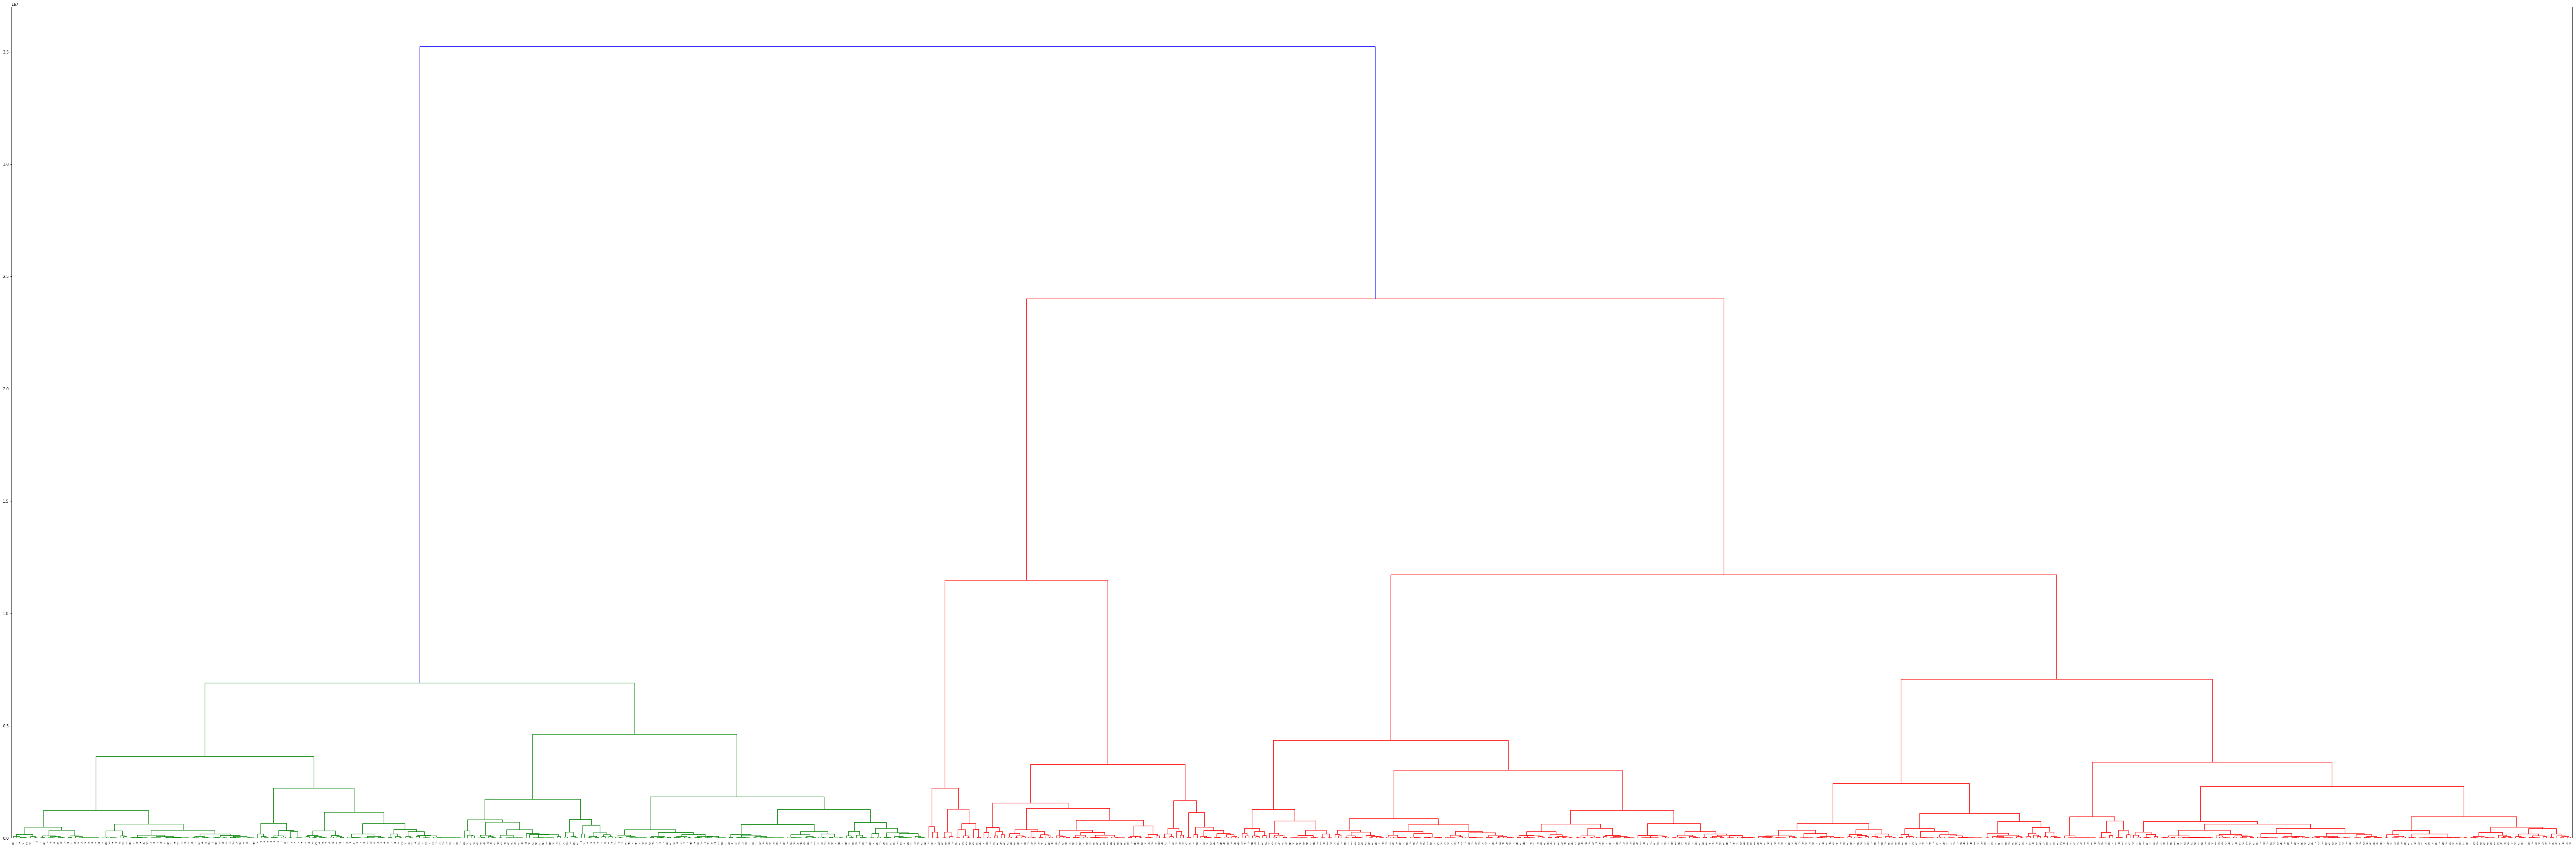

In [20]:
#Clustering aglomerativo jerarquico
#ward, complete
matrix = linkage(X, method='ward')

#Grafico del dendograma
plt.figure(figsize=(120, 40))
dendrogram(matrix)
plt.show()

In [13]:
#Formacion de los clusters a traves del clustering jerarquico aglomerativo
num_clusters=5
labels = fcluster(matrix, num_clusters, criterion='maxclust')
for i in range(len(labels)):
    print(X.axes[0][i],labels[i],'\n')

CFT_ANDRES_BELLO-TECNICO_EN_TRABAJO_SOCIAL 1 

CFT_DE_ENAC-TECNICO_EN_IMAGENOLOGIA_Y_RADIOTERAPIA 1 

CFT_DE_ENAC-TECNICO_EN_LABORATORIO_CLINICO_Y_BANCO_DE_SANGRE 1 

CFT_DE_TARAPACA-ASISTENCIA_JURIDICA 1 

CFT_ICEL-COCINA_NACIONAL_E_INTERNACIONAL 1 

CFT_ICEL-MECANICA_AUTOMOTRIZ 1 

CFT_ICEL-TECNICO_EN_EDUCACION_PARVULARIA 1 

CFT_ICEL-TECNICO_EN_ENFERMERIA 1 

CFT_ICEL-TECNICO_EN_ODONTOLOGIA 1 

CFT_ICEL-TECNICO_JURIDICO 1 

CFT_INACAP-ANALISTA_PROGRAMADOR 1 

CFT_INACAP-AUTOMATIZACION_Y_CONTROL_INDUSTRIAL 1 

CFT_INACAP-COMERCIO_EXTERIOR 1 

CFT_INACAP-CONTABILIDAD_GENERAL 1 

CFT_INACAP-ELECTRONICA_INDUSTRIAL 1 

CFT_INACAP-FABRICACION_Y_MONTAJE_INDUSTRIAL 1 

CFT_INACAP-GASTRONOMIA_INTERNACIONAL 1 

CFT_INACAP-LABORATORISTA_CLINICO,_BANCO_DE_SANGRE_E_IMAGENOLOGIA 1 

CFT_INACAP-MANTENIMIENTO_INDUSTRIAL 1 

CFT_INACAP-MECANICA_EN_PRODUCCION_INDUSTRIAL 1 

CFT_INACAP-TECNICO_EN_ENFERMERIA 1 

CFT_INACAP-TECNICO_EN_FARMACIA 1 

CFT_INACAP-TECNICO_EN_ODONTOLOGIA 1 

CFT_INACAP-TECNOLO


UNIVERSIDAD_DE_PLAYA_ANCHA_DE_CIENCIAS_DE_LA_EDUCACION-NUTRICION_Y_DIETETICA 4 

UNIVERSIDAD_DE_PLAYA_ANCHA_DE_CIENCIAS_DE_LA_EDUCACION-PEDAGOGIA_EN_EDUCACION_DIFERENCIAL 4 

UNIVERSIDAD_DE_PLAYA_ANCHA_DE_CIENCIAS_DE_LA_EDUCACION-PEDAGOGIA_EN_HISTORIA_Y_GEOGRAFIA 4 

UNIVERSIDAD_DE_PLAYA_ANCHA_DE_CIENCIAS_DE_LA_EDUCACION-PEDAGOGIA_EN_INGLES 4 

UNIVERSIDAD_DE_PLAYA_ANCHA_DE_CIENCIAS_DE_LA_EDUCACION-PERIODISMO 5 

UNIVERSIDAD_DE_PLAYA_ANCHA_DE_CIENCIAS_DE_LA_EDUCACION-TERAPIA_OCUPACIONAL 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-ADMINISTRACION_PUBLICA 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-ARQUITECTURA 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-CONTADOR_PUBLICO_Y_AUDITOR 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-ENFERMERIA 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-INGENIERIA_AMBIENTAL 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-INGENIERIA_CIVIL_EN_ELECTRICIDAD 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-INGENIERIA_CIVIL_EN_INFORMATICA 5 

UNIVERSIDAD_DE_SANTIAGO_DE_CHILE-INGENIERIA_CIVIL_EN_MECANICA 5 

UNIVERSIDAD_DE_SAN

In [14]:
#Reduccion de dimensionalidad de los datos mediante t-distributed Stochastic Neighbor Embedding.
X_embedded = TSNE(n_components=2).fit_transform(X)

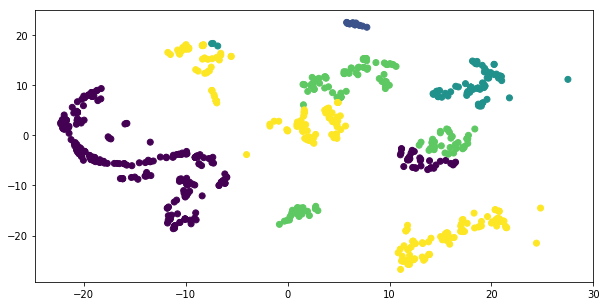

In [15]:
#Grafico de los datos en 2d con las etiquetas
plt.figure(figsize=(10, 5))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels) #Se agregan los labels de los clusters
plt.show()

In [16]:
#Normalizacion de los datos
#llaves = X.keys()
#X_norm=X
#for llave in llaves:
#    mini = min(X[llave])
#    maxi = max(X[llave])
#    X_norm[llave] = (X[llave] - mini)/(maxi - mini)

scaler=StandardScaler()
scaler.fit(X)
X_norm=scaler.transform(X)

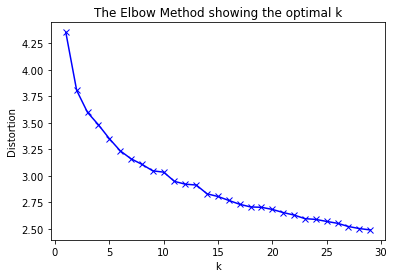

In [17]:
#Kmeans
# k means determine k
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X_norm)
    kmeanModel.fit(X_norm)
    distortions.append(sum(np.min(cdist(X_norm, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X_norm.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [18]:
clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X_norm)

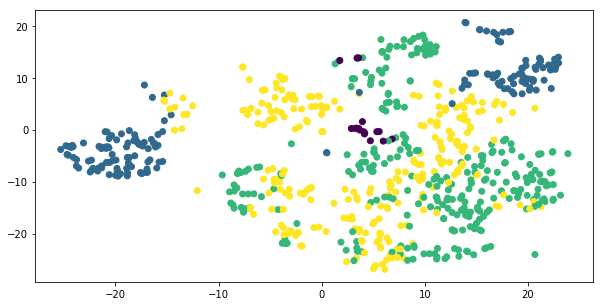

In [19]:
#Visualizacion de los datos mediante t-distributed Stochastic Neighbor Embedding.
X_embedded_kmeans = TSNE(n_components=2).fit_transform(X_norm)

plt.figure(figsize=(10, 5))
plt.scatter(X_embedded_kmeans[:, 0], X_embedded_kmeans[:, 1], c=cluster_labels) #Se agregan los labels de los clusters
plt.show()